<html><div style="font-size:7pt">This notebook may contain text, code and images generated by artificial intelligence. Used model: gpt-4o-2024-08-06, vision model: gpt-4o-2024-08-06, endpoint: None, bia-bob version: 0.21.1.. It is good scientific practice to check the code and results it produces carefully. <a href="https://github.com/haesleinhuepf/bia-bob">Read more about code generation using bia-bob</a></div></html>

# Applications of Variational Auto-Encoders (VAEs)

In this notebook, we will explore some practical applications of Variational Auto-Encoders (VAEs). We will provide examples of using VAEs for image generation and other practical applications.

## Image Generation

One of the most popular applications of VAEs is image generation. VAEs can be used to generate new images that are similar to the training data. Let's see how we can use a trained VAE to generate new images.

In [1]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

### Define the Encoder

The encoder network takes the input data and outputs the parameters of the latent distribution (mean and log variance).

In [2]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc2_log_var = nn.Linear(hidden_dim, latent_dim)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        h = self.relu(self.fc1(x))
        mean = self.fc2_mean(h)
        log_var = self.fc2_log_var(h)
        return mean, log_var

### Define the Decoder

The decoder network takes samples from the latent distribution and generates new data points.

In [3]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, z):
        h = self.relu(self.fc1(z))
        x_reconstructed = self.sigmoid(self.fc2(h))
        return x_reconstructed

### Define the VAE

The VAE model combines the encoder and decoder, and includes a sampling layer to sample from the latent distribution.

In [4]:
class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, x):
        mean, log_var = self.encoder(x)
        std = torch.exp(0.5 * log_var)
        epsilon = torch.randn_like(std)
        z = mean + std * epsilon
        x_reconstructed = self.decoder(z)
        return x_reconstructed, mean, log_var

### Define the Loss Function

The loss function consists of the reconstruction loss and the KL divergence.

In [5]:
def vae_loss(x, x_reconstructed, mean, log_var):
    reconstruction_loss = nn.functional.binary_cross_entropy(x_reconstructed, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reconstruction_loss + kl_divergence

### Train the VAE

Let's train the VAE on a simple dataset, such as the MNIST dataset.

In [6]:
# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# Define the VAE model
input_dim = 28 * 28
hidden_dim = 256
latent_dim = 2
encoder = Encoder(input_dim, hidden_dim, latent_dim)
decoder = Decoder(latent_dim, hidden_dim, input_dim)
vae = VAE(encoder, decoder)

# Define the optimizer
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    vae.train()
    train_loss = 0
    for x, _ in train_loader:
        optimizer.zero_grad()
        x_reconstructed, mean, log_var = vae(x)
        loss = vae_loss(x, x_reconstructed, mean, log_var)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f'Epoch {epoch + 1}, Loss: {train_loss / len(train_loader.dataset)}')

Epoch 1, Loss: 185.8339251871745
Epoch 2, Loss: 166.8651765625
Epoch 3, Loss: 163.44859486490884
Epoch 4, Loss: 161.4818348063151
Epoch 5, Loss: 159.99831422526043
Epoch 6, Loss: 158.78891735026042
Epoch 7, Loss: 157.77428404947918
Epoch 8, Loss: 156.8380381347656
Epoch 9, Loss: 156.01695650227865
Epoch 10, Loss: 155.277118351237


### Generate New Images

Now that we have trained the VAE, we can use it to generate new images.

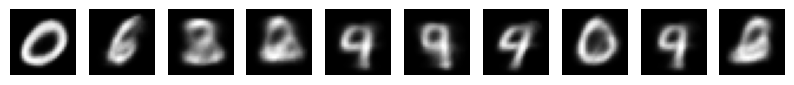

In [7]:
# Generate new data points
z_new = torch.randn(10, latent_dim)
with torch.no_grad():
    generated = vae.decoder(z_new)

# Plot the generated data points
plt.figure(figsize=(10, 2))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(generated[i].view(28, 28).numpy(), cmap='gray')
    plt.axis('off')
plt.show()

## Anomaly Detection

VAEs can also be used for anomaly detection. By training a VAE on normal data, we can use the reconstruction error to detect anomalies. Data points with high reconstruction error are likely to be anomalies.

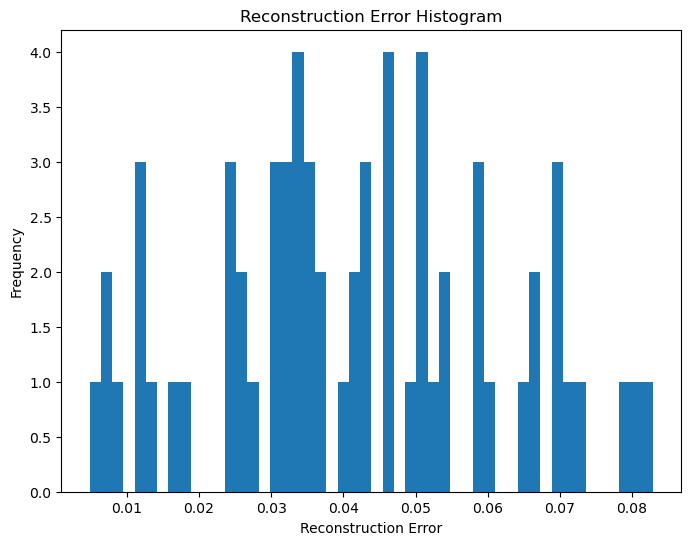

In [8]:
# Calculate reconstruction error for test data
vae.eval()
x_test = next(iter(test_loader))[0]  # Get the test data from DataLoader
with torch.no_grad():
    reconstructed, _, _ = vae(x_test)
    reconstruction_error = torch.mean((x_test - reconstructed) ** 2, axis=1)

# Plot reconstruction error
plt.figure(figsize=(8, 6))
plt.hist(reconstruction_error.numpy(), bins=50)
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Reconstruction Error Histogram')
plt.show()

## Data Compression

VAEs can be used for data compression by encoding the data into a lower-dimensional latent space. The latent representation can then be used to reconstruct the original data.

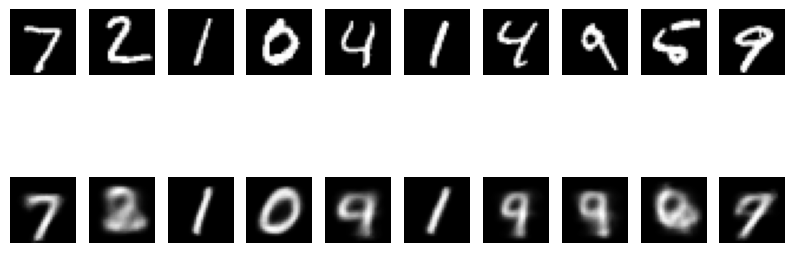

In [9]:
# Encode the test data to the latent space
vae.eval()
with torch.no_grad():
    mean, log_var = vae.encoder(x_test)
    std = torch.exp(0.5 * log_var)
    z = mean + std * torch.randn_like(std)

# Decode the latent representation to reconstruct the data
with torch.no_grad():
    reconstructed = vae.decoder(z)

# Plot original and reconstructed data
plt.figure(figsize=(10, 4))
for i in range(10):
    # Original data
    plt.subplot(2, 10, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    
    # Reconstructed data
    plt.subplot(2, 10, i + 11)
    plt.imshow(reconstructed[i].view(28, 28).numpy(), cmap='gray')
    plt.axis('off')
plt.show()